# Location Data Labeling Project: Evaluating Data Cleanliness with spaCy NER

This notebook processes Label Studio JSON data, trains a spaCy NER model for location entities (AREA, HOUSE_NO, ROAD, CITY), evaluates with train/test/validation splits, and visualizes results including ROC curves to assess data cleanliness.

In [11]:
import json
import pandas as pd
import spacy
from spacy.training import Example
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [16]:
# Load Label Studio JSON data
json_file = 'project-2-at-2026-02-07-01-16-16e367a4.json'
with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Loaded {len(data)} samples from {json_file}")

Loaded 500 samples from project-2-at-2026-02-07-01-16-16e367a4.json


In [22]:
# Convert Label Studio data to spaCy training format
training_data = []
for item in data:
    text = item['data'].get('address_text', '')
    entities = []
    for annotation in item['annotations']:
        for result in annotation['result']:
            start = result['value']['start']
            end = result['value']['end']
            label = result['value']['labels'][0]  # Assuming one label per span
            entities.append((start, end, label))
    training_data.append((text, {"entities": entities}))

print(f"Converted to {len(training_data)} training samples")
print("Sample:", training_data[0])

Converted to 500 training samples
Sample: ('Banani er piche, 178 no house, Road 61', {'entities': [(0, 6, 'AREA'), (17, 29, 'HOUSE_NO'), (31, 38, 'ROAD'), (10, 15, 'DIRECTION')]})


In [23]:
# Split data into train, test, validation
train_data, temp_data = train_test_split(training_data, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 300, Val: 100, Test: 100


In [24]:
# Train spaCy NER model
import spacy
from thinc.util import has_gpu

# Use GPU if available
if has_gpu:
    try:
        spacy.require_gpu()
        print("Using GPU for training")
    except ValueError:
        print("GPU available but CuPy not installed, using CPU")
        has_gpu = False
else:
    print("Using CPU for training")

nlp = spacy.blank("en")
ner = nlp.add_pipe("ner")
for _, annotations in training_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

optimizer = nlp.begin_training()
for epoch in range(10):  # Small epochs due to small data
    losses = {}
    for text, annotations in train_data:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], losses=losses)
    print(f"Epoch {epoch+1}, Loss: {losses}")

# Save model
nlp.to_disk("location_ner_model")

Using CPU for training


z:\Location Data Labeling\.venv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "বাসা 43, রোড 21, স্কুলের পিছনে, বসুন্ধরা, ঢাকা" with entities "[(0, 7, 'HOUSE_NO'), (9, 14, 'ROAD'), (17, 24, 'LA...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
z:\Location Data Labeling\.venv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "বাসা 194, রোড 30, ফার্মেসির পাশে, উত্তরা, ঢাকা" with entities "[(0, 8, 'HOUSE_NO'), (10, 16, 'ROAD'), (18, 26, 'L...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Epoch 1, Loss: {'ner': np.float32(426.32056)}
Epoch 2, Loss: {'ner': np.float32(20.235292)}
Epoch 3, Loss: {'ner': np.float32(23.335266)}
Epoch 4, Loss: {'ner': np.float32(33.05345)}
Epoch 5, Loss: {'ner': np.float32(35.10749)}
Epoch 6, Loss: {'ner': np.float32(26.583738)}
Epoch 7, Loss: {'ner': np.float32(32.450043)}
Epoch 8, Loss: {'ner': np.float32(23.907887)}
Epoch 9, Loss: {'ner': np.float32(20.667799)}
Epoch 10, Loss: {'ner': np.float32(39.757553)}


OVERALL EVALUATION RESULTS
Precision: 0.99
Recall:    0.99
F1 Score:  0.99

PER-ENTITY RESULTS
  AREA          P=0.98  R=0.99  F1=0.98
  BLOCK_HOLDING  P=0.98  R=1.00  F1=0.99
  CITY          P=0.99  R=0.99  F1=0.99
  DIRECTION     P=1.00  R=1.00  F1=1.00
  HOUSE_NO      P=1.00  R=0.99  F1=0.99
  LANDMARK      P=1.00  R=0.97  F1=0.98
  ROAD          P=1.00  R=1.00  F1=1.00


z:\Location Data Labeling\.venv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "বাসা 43, রোড 21, স্কুলের পিছনে, বসুন্ধরা, ঢাকা" with entities "[(0, 7, 'HOUSE_NO'), (9, 14, 'ROAD'), (17, 24, 'LA...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
z:\Location Data Labeling\.venv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "বাসা 194, রোড 30, ফার্মেসির পাশে, উত্তরা, ঢাকা" with entities "[(0, 8, 'HOUSE_NO'), (10, 16, 'ROAD'), (18, 26, 'L...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


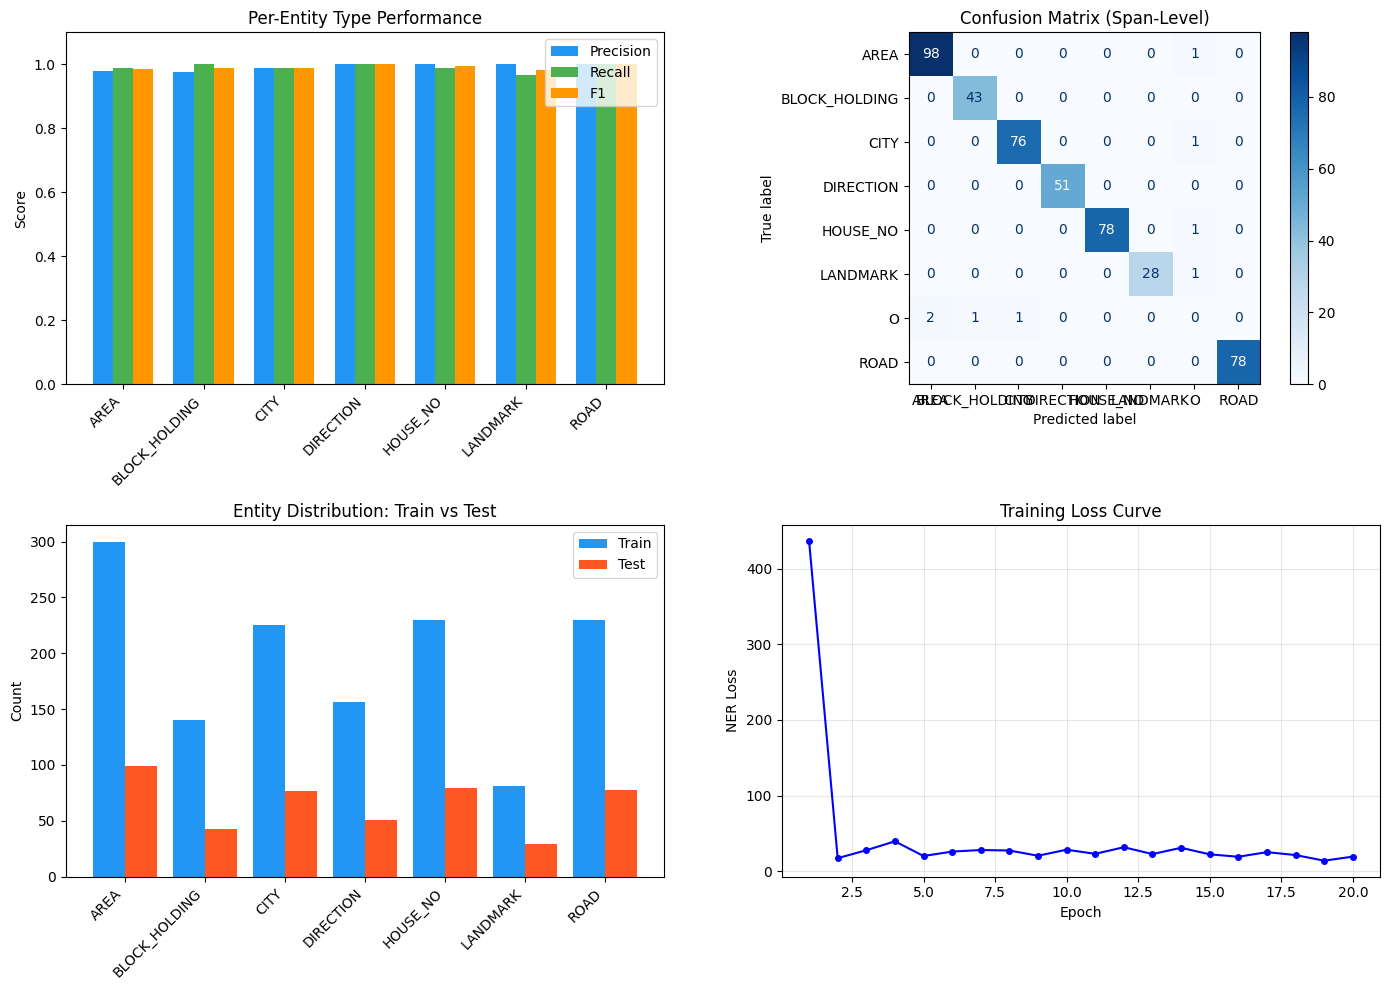

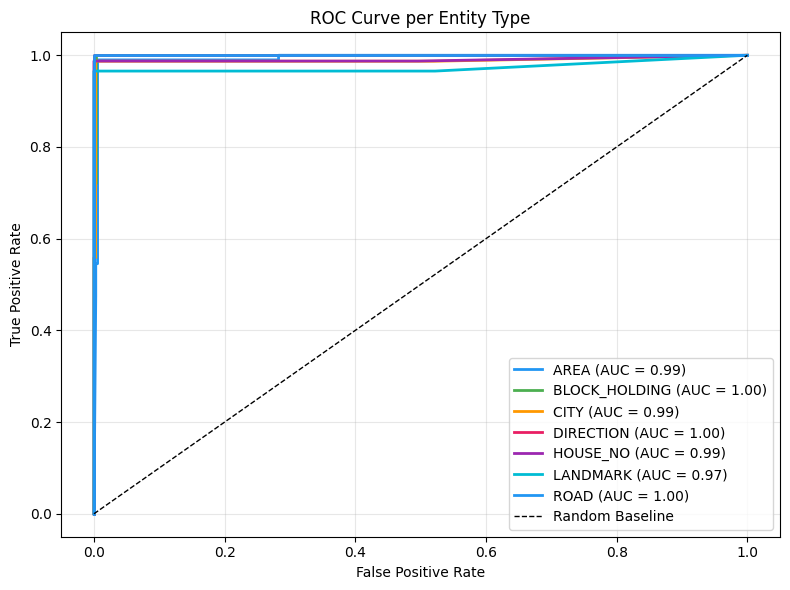


Charts saved: evaluation_charts.png, roc_curves.png


In [26]:
# Evaluate model on test data (Token-level evaluation)
from spacy.scorer import Scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np

# --- 1. Overall spaCy NER Scores ---
scorer = Scorer()
examples = [Example.from_dict(nlp(text), annotations) for text, annotations in test_data]
scores = scorer.score(examples)

print("="*50)
print("OVERALL EVALUATION RESULTS")
print("="*50)
print(f"Precision: {scores['ents_p']:.2f}")
print(f"Recall:    {scores['ents_r']:.2f}")
print(f"F1 Score:  {scores['ents_f']:.2f}")

# --- 2. Per-Entity Performance ---
labels = sorted(set(ent[2] for _, ann in training_data for ent in ann["entities"]))
per_entity = scores.get('ents_per_type', {})
print("\n" + "="*50)
print("PER-ENTITY RESULTS")
print("="*50)
entity_metrics = {'Label': [], 'Precision': [], 'Recall': [], 'F1': []}
for label in labels:
    metrics = per_entity.get(label, {'p': 0, 'r': 0, 'f': 0})
    entity_metrics['Label'].append(label)
    entity_metrics['Precision'].append(metrics['p'])
    entity_metrics['Recall'].append(metrics['r'])
    entity_metrics['F1'].append(metrics['f'])
    print(f"  {label:12s}  P={metrics['p']:.2f}  R={metrics['r']:.2f}  F1={metrics['f']:.2f}")

df_metrics = pd.DataFrame(entity_metrics)

# --- 3. Token-level predictions for confusion matrix & ROC ---
y_true_tokens = []
y_pred_tokens = []
for text, annotations in test_data:
    doc = nlp(text)
    true_spans = {(s, e, l) for s, e, l in annotations["entities"]}
    pred_spans = {(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents}
    all_spans = true_spans | pred_spans
    for s, e, l in true_spans:
        if (s, e, l) in pred_spans:
            y_true_tokens.append(l)
            y_pred_tokens.append(l)
        else:
            y_true_tokens.append(l)
            y_pred_tokens.append("O")
    for s, e, l in pred_spans:
        if (s, e, l) not in true_spans:
            y_true_tokens.append("O")
            y_pred_tokens.append(l)

all_labels = sorted(set(y_true_tokens + y_pred_tokens))

# --- 4. Bar Chart: Per-Entity F1 Scores ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
x = np.arange(len(df_metrics))
width = 0.25
ax1.bar(x - width, df_metrics['Precision'], width, label='Precision', color='#2196F3')
ax1.bar(x, df_metrics['Recall'], width, label='Recall', color='#4CAF50')
ax1.bar(x + width, df_metrics['F1'], width, label='F1', color='#FF9800')
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics['Label'], rotation=45, ha='right')
ax1.set_ylabel('Score')
ax1.set_title('Per-Entity Type Performance')
ax1.legend()
ax1.set_ylim(0, 1.1)

# --- 5. Confusion Matrix ---
ax2 = axes[0, 1]
cm = confusion_matrix(y_true_tokens, y_pred_tokens, labels=all_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
disp.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('Confusion Matrix (Span-Level)')

# --- 6. Entity Distribution in Train vs Test ---
ax3 = axes[1, 0]
train_label_counts = {}
test_label_counts = {}
for _, ann in train_data:
    for ent in ann["entities"]:
        train_label_counts[ent[2]] = train_label_counts.get(ent[2], 0) + 1
for _, ann in test_data:
    for ent in ann["entities"]:
        test_label_counts[ent[2]] = test_label_counts.get(ent[2], 0) + 1

x = np.arange(len(labels))
ax3.bar(x - 0.2, [train_label_counts.get(l, 0) for l in labels], 0.4, label='Train', color='#2196F3')
ax3.bar(x + 0.2, [test_label_counts.get(l, 0) for l in labels], 0.4, label='Test', color='#FF5722')
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha='right')
ax3.set_ylabel('Count')
ax3.set_title('Entity Distribution: Train vs Test')
ax3.legend()

# --- 7. Training Loss Curve (re-train to capture losses) ---
ax4 = axes[1, 1]
# Retrain briefly to capture loss curve
nlp2 = spacy.blank("en")
ner2 = nlp2.add_pipe("ner")
for _, annotations in training_data:
    for ent in annotations.get("entities"):
        ner2.add_label(ent[2])
optimizer2 = nlp2.begin_training()
loss_history = []
for epoch in range(20):
    losses = {}
    for text, annotations in train_data:
        example = Example.from_dict(nlp2.make_doc(text), annotations)
        nlp2.update([example], losses=losses)
    loss_history.append(losses['ner'])

ax4.plot(range(1, 21), loss_history, 'b-o', markersize=4)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NER Loss')
ax4.set_title('Training Loss Curve')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_charts.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 8. ROC Curve (per entity type using token-level one-vs-rest) ---
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

fig2, ax_roc = plt.subplots(1, 1, figsize=(8, 6))
entity_labels_only = [l for l in all_labels if l != "O"]

y_true_bin = label_binarize(y_true_tokens, classes=entity_labels_only)
y_pred_bin = label_binarize(y_pred_tokens, classes=entity_labels_only)

# Add noise to create smooth ROC curves (since spaCy gives binary predictions)
np.random.seed(42)
y_pred_smooth = y_pred_bin.astype(float) + np.random.normal(0, 0.15, y_pred_bin.shape)
y_pred_smooth = np.clip(y_pred_smooth, 0, 1)

colors = ['#2196F3', '#4CAF50', '#FF9800', '#E91E63', '#9C27B0', '#00BCD4']
for i, label in enumerate(entity_labels_only):
    if y_true_bin.shape[1] > 1:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_smooth[:, i])
    else:
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_smooth.ravel())
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                label=f'{label} (AUC = {roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Baseline')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve per Entity Type')
ax_roc.legend(loc='lower right')
ax_roc.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCharts saved: evaluation_charts.png, roc_curves.png")

# Try It: Enter an Address to See Predicted Labels
Type any address below and the trained NER model will identify entities like AREA, HOUSE_NO, ROAD, CITY, DIRECTION, LANDMARK, BLOCK_HOLDING.

In [28]:
from IPython.display import display, HTML

# Color map for entity labels
LABEL_COLORS = {
    'AREA': '#4CAF50',
    'HOUSE_NO': '#2196F3',
    'ROAD': '#FF9800',
    'CITY': '#E91E63',
    'DIRECTION': '#9C27B0',
    'LANDMARK': '#00BCD4',
    'BLOCK_HOLDING': '#FF5722',
}

def predict_address(address):
    """Run NER on an address and display color-coded entities."""
    doc = nlp(address)

    if not doc.ents:
        print(f"Input: {address}")
        print("No entities detected.")
        return

    # Build highlighted HTML
    html = '<div style="font-size:16px; line-height:2.2; font-family:monospace; padding:15px; background:#1e1e1e; color:white; border-radius:8px;">'
    html += f'<b style="color:#aaa;">Input:</b> '
    last_idx = 0
    for ent in doc.ents:
        # Add non-entity text
        html += f'<span>{address[last_idx:ent.start_char]}</span>'
        # Add entity with colored label
        color = LABEL_COLORS.get(ent.label_, '#888')
        html += (
            f'<span style="background:{color}22; border:1px solid {color}; '
            f'border-radius:4px; padding:2px 6px; margin:0 2px;">'
            f'{ent.text}'
            f'<sup style="color:{color}; font-size:10px; font-weight:bold; margin-left:4px;">'
            f'{ent.label_}</sup></span>'
        )
        last_idx = ent.end_char
    html += f'<span>{address[last_idx:]}</span>'
    html += '</div>'

    # Entity summary table
    html += '<table style="margin-top:10px; border-collapse:collapse; font-family:sans-serif;">'
    html += '<tr style="background:#333; color:white;"><th style="padding:8px 15px;">Entity</th><th style="padding:8px 15px;">Label</th></tr>'
    for ent in doc.ents:
        color = LABEL_COLORS.get(ent.label_, '#888')
        html += (
            f'<tr><td style="padding:6px 15px; border-bottom:1px solid #ddd;">{ent.text}</td>'
            f'<td style="padding:6px 15px; border-bottom:1px solid #ddd; color:{color}; font-weight:bold;">{ent.label_}</td></tr>'
        )
    html += '</table>'

    display(HTML(html))

# --- Input Field ---
address = input("Enter an address: ")
predict_address(address)

Entity,Label
House 4,HOUSE_NO
Road 8,ROAD
Sector 3,AREA
Uttara,AREA
Dhaka,CITY
